In [299]:
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [300]:
# define the fonts and colors to use for plots
family = 'Helvetica'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
bar_edge_color = '#272727'
yellow = '#FFE400'
green = '#14A76C'
orange = '#FF652F'

# Loading source data

In [301]:
# load the messages csv data file
data = pd.read_csv('../resources/messages.csv')

emoji_table = pd.read_csv('../resources/emoji-data-table.csv')

# extract emojis
all_emoji_strings = [*filter(lambda emoji : type(emoji) is str, data['emojis'])]
# convert strings to character lists
all_emojis_2d = [*map(lambda emoji_string : list(emoji_string), all_emoji_strings)]
# flatten 2d list
all_emojis = [item for sublist in all_emojis_2d for item in sublist]

def get_emoji_img_url(emoji):
    for i in range(len(emoji_table)): 
        if emoji_table.values[i][0] == emoji:
            return emoji_table.values[i][4]
        
def get_emoji_img(emoji, size):
    url = get_emoji_img_url(emoji)
    url = url if type(url) == str else get_emoji_img_url('❓')
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.thumbnail((size, size), Image.ANTIALIAS)
    return img

In [304]:
# this many emojis will be ranked on the barchart
emojis_to_rank = 10
emoji_counts = pd.Series(all_emojis).value_counts().sort_values(ascending=False)
emoji_counts[:emojis_to_rank]

😂    19860
❤     5369
😁     1959
😍     1687
😘     1363
😄      968
💋      728
😊      604
😭      505
✋      500
dtype: int64

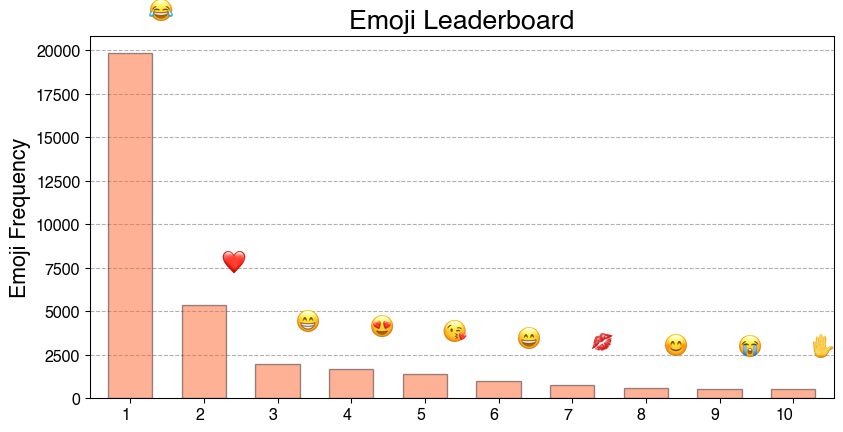

In [305]:
fig = plt.figure(figsize=[10, 5], dpi=96)
ax = emoji_counts[:emojis_to_rank].plot(kind='bar', width=0.6, alpha=0.5, color=orange, edgecolor=bar_edge_color, zorder=2)

xlabels = [*range(1, emojis_to_rank+1)]
ax.yaxis.grid(True, linestyle='--')
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Emoji Leaderboard', fontproperties=title_font)
ax.set_xlabel('')
ax.set_ylabel('Emoji Frequency', fontproperties=label_font)
    
bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]

for i in range(0, len(bars)-1):
    bar = bars[i]
    data_bbox = bar.get_bbox()
    display_bbox = data_bbox.transformed(ax.transData)
    img = get_emoji_img(emoji_counts.index[i], 24)
    bar_center_x = (display_bbox.x0 + display_bbox.x1) / 2
    img_x = bar_center_x - img.width / 2
    img_y = display_bbox.y1 + 5
    fig.figimage(img, img_x, img_y)

fig.savefig('images/messenger-emoji-leaderboard.png', dpi=96)
plt.show()